<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/Quora-Question-Dupe-Check-Similarity-Check/quora_dupe_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration

In [2]:
!wget http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv

--2026-01-01 18:38:10--  http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv
Resolving qim.fs.quoracdn.net (qim.fs.quoracdn.net)... 162.159.152.17, 162.159.153.247
Connecting to qim.fs.quoracdn.net (qim.fs.quoracdn.net)|162.159.152.17|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://qim.fs.quoracdn.net/quora_duplicate_questions.tsv [following]
--2026-01-01 18:38:10--  https://qim.fs.quoracdn.net/quora_duplicate_questions.tsv
Connecting to qim.fs.quoracdn.net (qim.fs.quoracdn.net)|162.159.152.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58176133 (55M) [text/tab-separated-values]
Saving to: ‘quora_duplicate_questions.tsv’

quora_duplicate_que 100%[===================>]  55.48M  81.0MB/s    in 0.7s    

2026-01-01 18:38:11 (81.0 MB/s) - ‘quora_duplicate_questions.tsv’ saved [58176133/58176133]



In [3]:
MAX_WORDS = 10_000
MAX_LEN = 50
EMBEDDING_DIM = 50
BATCH_SIZE = 64
EPOCHS = 20

def load_data(path):
    print(f"Downloading Quora Dataset....")
    # url = "http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv"
    # path = tf.keras.utils.get_file("quora_duplicate_questions.tsv", url)
    df = pd.read_csv(path, sep="\t")
    df = df.dropna()
    df = df.sample(20_000, random_state=42)
    print(f"Data Loaded. Shape: {df.shape}")
    return df

df = load_data("/content/quora_duplicate_questions.tsv")

Data Loaded. Shape: (20000, 6)


In [4]:
# List of question
q1_list = df["question1"].astype(str).tolist()
q2_list = df["question2"].astype(str).tolist()
labels = df['is_duplicate'].values

# Build tokenizer
print("Tokenizing Texts...")
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(q1_list + q2_list)

# Test-to-Interger
q1_seq = tokenizer.texts_to_sequences(q1_list)
q2_seq = tokenizer.texts_to_sequences(q2_list)

# Padding
q1_data = pad_sequences(q1_seq, maxlen=MAX_LEN)
q2_data = pad_sequences(q2_seq, maxlen=MAX_LEN)

# Val/Train
split= int(len(q1_data) * 0.8)
q1_train, q1_val = q1_data[:split], q1_data[split:]
q2_train, q2_val = q2_data[:split], q2_data[split:]
y_train, y_val = labels[:split], labels[split:]

print("Preprocessing Complete...")

Tokenizing Texts...
Preprocessing Complete...


# Model Definition

In [5]:
def build_model():
    # Define inputs
    input_q1 = Input(shape=(MAX_LEN,), name="left_input")
    input_q2 = Input(shape=(MAX_LEN,), name="right_input")

    # Shared layer
    # This layer instantiated one time but we will
    # call it twice.
    shared_embedding = layers.Embedding(
        input_dim=MAX_WORDS,
        output_dim=EMBEDDING_DIM,
        name="shared_embedding"
    )
    shared_lstm = layers.LSTM(
        units=128,
        name="shared_lstm"
    )
    # Left input
    encoded_q1 = shared_embedding(input_q1)
    encoded_q1 = shared_lstm(encoded_q1)
    # Right input
    encoded_q2 = shared_embedding(input_q2)
    encoded_q2 = shared_lstm(encoded_q2)

    # Distance layer
    # Used to calculate distance to measure similarity
    diff = layers.Subtract()([encoded_q1, encoded_q2])
    distance = layers.Lambda(tf.abs)(diff)

    # Classification head
    output = layers.Dense(1, activation="sigmoid", name="output")(distance)

    # Define model
    model = models.Model(
        inputs=[input_q1, input_q2],
        outputs=output,
        name="Quora_Model"
    )
    return model

model = build_model()
model.summary()

Model: "Quora_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ left_input          │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right_input         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_embedding    │ (None, 50, 50)    │    500,000 │ left_input[0][0], │
│ (Embedding)         │                   │            │ right_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_lstm (LSTM)  │ (None, 128)       │     91,648 │ shared_embedding… │
│                     │                   │            │ shared_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 128)       │          0 │ shared_lstm[0][0… │
│                     │                   │            │ shared_lstm[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ subtract[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        129 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 591,777 (2.26 MB)

 Trainable params: 591,777 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

## Visualize the Model

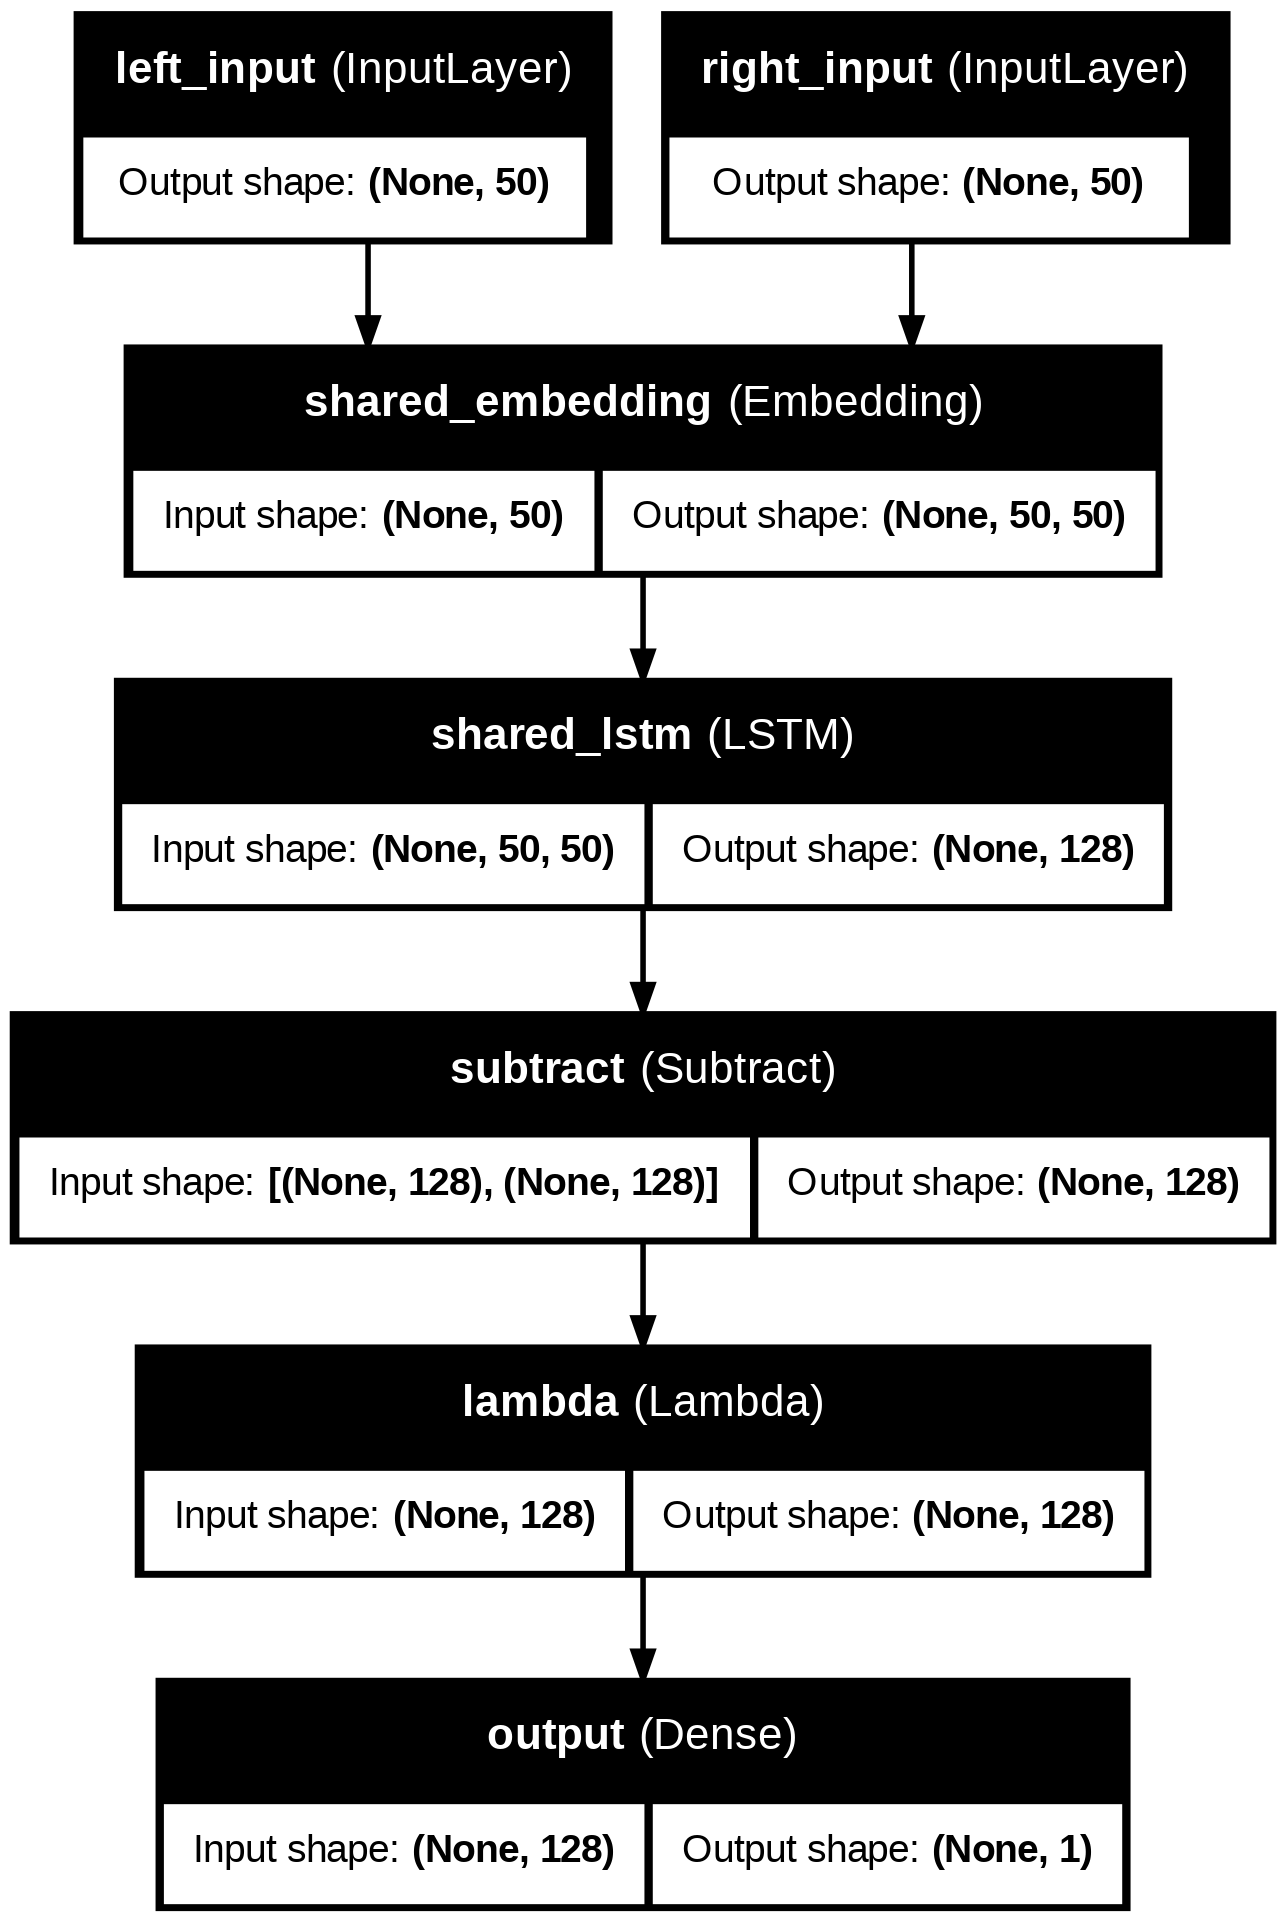

In [6]:
from keras.utils import plot_model
plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True)

# Compile & Train

In [7]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    x=[q1_train, q2_train],
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([q1_val, q2_val], y_val)
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6199 - loss: 0.6481 - val_accuracy: 0.6270 - val_loss: 0.6207
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6370 - loss: 0.5803 - val_accuracy: 0.6413 - val_loss: 0.6069
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7131 - loss: 0.4947 - val_accuracy: 0.6950 - val_loss: 0.5910
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8185 - loss: 0.3878 - val_accuracy: 0.6908 - val_loss: 0.6153
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8651 - loss: 0.3087 - val_accuracy: 0.6982 - val_loss: 0.7021
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8981 - loss: 0.2420 - val_accuracy: 0.6842 - val_loss: 0.7525
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9250 - loss: 0.1887 - val_accuracy: 0.6655 - val_loss: 0.8691
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9413 - loss: 0.1502 - val_accurac

# Inference

In [18]:
def check_similarity(text1, text2):
    # Preprocessing
    s1 = tokenizer.texts_to_sequences([text1])
    s2 = tokenizer.texts_to_sequences([text2])

    # Padding
    p1 = pad_sequences(s1, maxlen=MAX_LEN)
    p2 = pad_sequences(s2, maxlen=MAX_LEN)

    # Predictions
    pred = model.predict([p1, p2], verbose=0)[0][0]
    # Show predictions
    is_duplicate = pred > 0.5
    color = "green" if is_duplicate else "red"
    label = "Duplicate" if is_duplicate else "Different"

    print("-" * 40)
    print(f"Q1: {text1}")
    print(f"Q2: {text2}")
    print(f"Similarity Score: {pred:.4f} -> {label}")


In [19]:
check_similarity("How do I learn Python?",
                 "What is the best way to learn Python programming?")


----------------------------------------
Q1: How do I learn Python?
Q2: What is the best way to learn Python programming?
Similarity Score: 0.8171 -> Duplicate


In [20]:
check_similarity("How do I learn Python?",
                 "How do I make pizza?")

----------------------------------------
Q1: How do I learn Python?
Q2: How do I make pizza?
Similarity Score: 0.0437 -> Different


In [21]:
check_similarity("Is it good to eat late at night?",
                 "Is it bad to eat before sleeping?")

----------------------------------------
Q1: Is it good to eat late at night?
Q2: Is it bad to eat before sleeping?
Similarity Score: 0.0000 -> Different
